In [43]:
sec_norm = 410
n = 30  # Number of values to predict at a time
input_size = n  # Input is a window of size n
k = 1 # Hidden size
output_size = n  # Output is a window of size n
num_epochs = 50
batch_size = 16
learning_rate = 0.001
cutoff = 50 #cutting of time it takes to lift off
norm_upper = 3.7
norm_lower = 2.3
train_dir = (['data/5-2-25/'])
test_dir = (['data/31-1-25/'])

In [44]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import maketab as mt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

import math
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern font for math text

In [45]:
def norm(signal):
    signal = (signal - norm_lower) / (norm_upper - norm_lower)
    return signal

def normalize(arr):
    min_val = min(arr)
    max_val = max(arr)
    print(min_val, max_val)
    if min_val == max_val:
        return [0.0] * len(arr)  # Avoid division by zero if all elements are the same
    return [(x - min_val) / (max_val - min_val) for x in arr]

def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    secleft = t[-1]/1000
    tleft = 1 - t / max(t)
    tleft = tleft*(secleft/sec_norm)
    signal = norm(signal[cutoff:])
    tleft = tleft[cutoff:]
    t = t[cutoff:]
    normalized_train = np.array([signal, tleft])
    return normalized_train


def make_data(train_dir):
    if(len(train_dir) == 1):
        for d in train_dir:
            train_data = load_data(d)
        #plt.plot(train_data[0])
        #plt.plot(train_data[1])
        #plt.show()
        return train_data
    else:
        train_data = np.empty((len(train_dir), 0))
        for d in train_dir:
            single_data = load_data(d)
            train_data = np.concatenate((train_data, single_data), axis=1)
        #plt.plot(train_data[0])
        #plt.plot(train_data[1])
        #plt.plot(train_data[2])
        #plt.show()
        return train_data

In [46]:
class FunctionDataset(Dataset):
    def __init__(self, data, n):
        self.g = data[0]  # Function g
        self.f = data[1]  # Function f
        self.n = n  # Sequence length
        self.total_length = len(self.g)

    def __len__(self):
        # The number of sequences is the total length minus the sequence length plus 1
        return self.total_length - self.n + 1

    def __getitem__(self, idx):
        # Get a sequence of g and the corresponding sequence of f
        g_seq = self.g[idx:idx + self.n]
        f_seq = self.f[idx:idx + self.n]
        
        # Convert to PyTorch tensors
        g_tensor = torch.tensor(g_seq, dtype=torch.float32)
        f_tensor = torch.tensor(f_seq, dtype=torch.float32)
        
        return g_tensor, f_tensor

def create_dataloader(data, seq_length, batch_size=1, shuffle=False):
    dataset = FunctionDataset(data, seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Example usage:
data = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # g
    [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # f
])

dataset = FunctionDataset(data, n=4)
for i in range(min(10, len(dataset))):  # Print first 5 samples
    data, target = dataset[i]
    print(f"Sample {i}: Data={data}, Target={target}")
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
# Iterate through the DataLoader
for g_batch, f_batch in dataloader:
    print("g_batch:", g_batch)
    print("f_batch:", f_batch)

Sample 0: Data=tensor([1., 2., 3., 4.]), Target=tensor([10., 20., 30., 40.])
Sample 1: Data=tensor([2., 3., 4., 5.]), Target=tensor([20., 30., 40., 50.])
Sample 2: Data=tensor([3., 4., 5., 6.]), Target=tensor([30., 40., 50., 60.])
Sample 3: Data=tensor([4., 5., 6., 7.]), Target=tensor([40., 50., 60., 70.])
Sample 4: Data=tensor([5., 6., 7., 8.]), Target=tensor([50., 60., 70., 80.])
Sample 5: Data=tensor([6., 7., 8., 9.]), Target=tensor([60., 70., 80., 90.])
Sample 6: Data=tensor([ 7.,  8.,  9., 10.]), Target=tensor([ 70.,  80.,  90., 100.])
g_batch: tensor([[4., 5., 6., 7.],
        [3., 4., 5., 6.],
        [1., 2., 3., 4.]])
f_batch: tensor([[40., 50., 60., 70.],
        [30., 40., 50., 60.],
        [10., 20., 30., 40.]])
g_batch: tensor([[ 5.,  6.,  7.,  8.],
        [ 6.,  7.,  8.,  9.],
        [ 7.,  8.,  9., 10.]])
f_batch: tensor([[ 50.,  60.,  70.,  80.],
        [ 60.,  70.,  80.,  90.],
        [ 70.,  80.,  90., 100.]])
g_batch: tensor([[2., 3., 4., 5.]])
f_batch: tensor([

In [7]:
# Print dataset information
dataset = FunctionDataset(load_data('data/5-2-25/'), 10)

print(f"Dataset length: {len(dataset)}")
print(f"Sequence length (n): {dataset.n}")
print(f"Total length of functions: {dataset.total_length}")

# Print first few samples
print("\nFirst 5 samples:")
for i in range(min(5, len(dataset))):
    g_seq, f_seq = dataset[i]
    print(f"Sample {i}:")
    print(f"  g sequence: {g_seq}")
    print(f"  f sequence: {f_seq}")
    print()

# Print last few samples
print("\nLast 5 samples:")
for i in range(max(0, len(dataset)-5), len(dataset)):
    g_seq, f_seq = dataset[i]
    print(f"Sample {i}:")
    print(f"  g sequence: {g_seq}")
    print(f"  f sequence: {f_seq}")
    print()

Dataset length: 3976
Sequence length (n): 10
Total length of functions: 3985

First 5 samples:
Sample 0:
  g sequence: tensor([0.9663, 0.9663, 0.9776, 0.9700, 0.9738, 0.9738, 0.9700, 0.9625, 0.9587,
        0.9663])
  f sequence: tensor([0.9717, 0.9715, 0.9712, 0.9710, 0.9707, 0.9705, 0.9702, 0.9700, 0.9698,
        0.9695])

Sample 1:
  g sequence: tensor([0.9663, 0.9776, 0.9700, 0.9738, 0.9738, 0.9700, 0.9625, 0.9587, 0.9663,
        0.9663])
  f sequence: tensor([0.9715, 0.9712, 0.9710, 0.9707, 0.9705, 0.9702, 0.9700, 0.9698, 0.9695,
        0.9693])

Sample 2:
  g sequence: tensor([0.9776, 0.9700, 0.9738, 0.9738, 0.9700, 0.9625, 0.9587, 0.9663, 0.9663,
        0.9625])
  f sequence: tensor([0.9712, 0.9710, 0.9707, 0.9705, 0.9702, 0.9700, 0.9698, 0.9695, 0.9693,
        0.9690])

Sample 3:
  g sequence: tensor([0.9700, 0.9738, 0.9738, 0.9700, 0.9625, 0.9587, 0.9663, 0.9663, 0.9625,
        0.9700])
  f sequence: tensor([0.9710, 0.9707, 0.9705, 0.9702, 0.9700, 0.9698, 0.9695, 0.9693,

In [9]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights (parameters)
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        
        # Initialize bias if needed
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
    def forward(self, input):
        # Perform the linear transformation
        output = input.matmul(self.weight.t())
        
        # Add bias if it exists
        if self.bias is not None:
            output += self.bias
            
        return output
        
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

In [47]:
class QNU(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True, activation=None):
        super(QNU, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.activation = activation

        # Linear weights: shape [output_dim, input_dim]
        self.linear = nn.Parameter(torch.randn(output_dim, input_dim))
        
        # Quadratic weights: shape [output_dim, input_dim, input_dim]
        self.quadratic = nn.Parameter(torch.randn(output_dim, input_dim, input_dim))
        nn.init.normal_(self.quadratic, mean=0.0, std=0.01)

        if use_bias:
            self.bias = nn.Parameter(torch.randn(output_dim))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def forward(self, x):
        # x shape: [batch_size, input_dim]
        batch_size = x.size(0)

        # Linear term: [batch_size, output_dim]
        linear_term = torch.matmul(x, self.linear.t())

        # Quadratic term
        # Step 1: Expand input for broadcasting: [batch_size, input_dim, 1] x [batch_size, 1, input_dim]
        x_expanded = x.unsqueeze(2)  # [batch_size, input_dim, 1]
        x_transpose = x.unsqueeze(1) # [batch_size, 1, input_dim]
        x_outer = x_expanded @ x_transpose  # [batch_size, input_dim, input_dim]

        # Step 2: Multiply by quadratic weights and sum: [batch_size, output_dim]
        quad_term = torch.einsum('bij,oij->bo', x_outer, self.quadratic)

        out = linear_term + quad_term

        if self.use_bias:
            out = out + self.bias

        if self.activation is not None:
            out = self.activation(out)

        return out

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.linear, a=math.sqrt(5))
        nn.init.uniform_(self.quadratic, a=-0.01, b=0.01)  # Small init for stability
        if self.use_bias:
            fan_in = self.input_dim
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

In [48]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = QNU(input_size, hidden_size, activation=nn.ReLU())
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out

# Initialize model
model = MLP(n, k, n)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
def train(num_epochs, dataloader, model, criterion, optimizer):
    epoch_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # To accumulate loss for the entire epoch
        num_batches = 0
        for batch_X, batch_Y in dataloader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
            num_batches += 1
        avg_loss = (epoch_loss / num_batches)
        epoch_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.8f}')
    plt.plot(epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

Epoch [10/50], Average Loss: 0.07820499
Epoch [20/50], Average Loss: 0.07756264
Epoch [30/50], Average Loss: 0.07740623
Epoch [40/50], Average Loss: 0.07762862
Epoch [50/50], Average Loss: 0.07758561


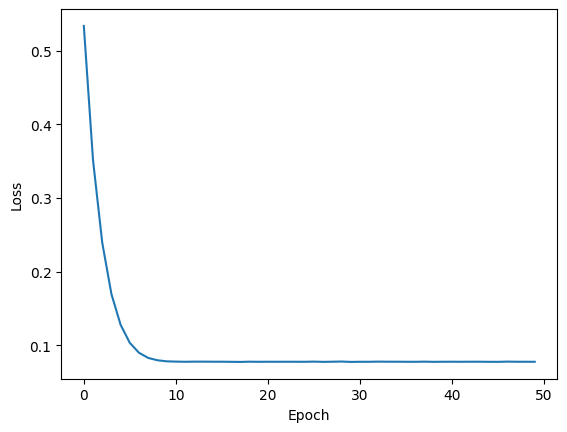

In [50]:
for d in train_dir:
    train_data = load_data(d)
    dataloader = create_dataloader(train_data, n, batch_size=batch_size, shuffle=True)
    train(num_epochs, dataloader, model, criterion, optimizer)

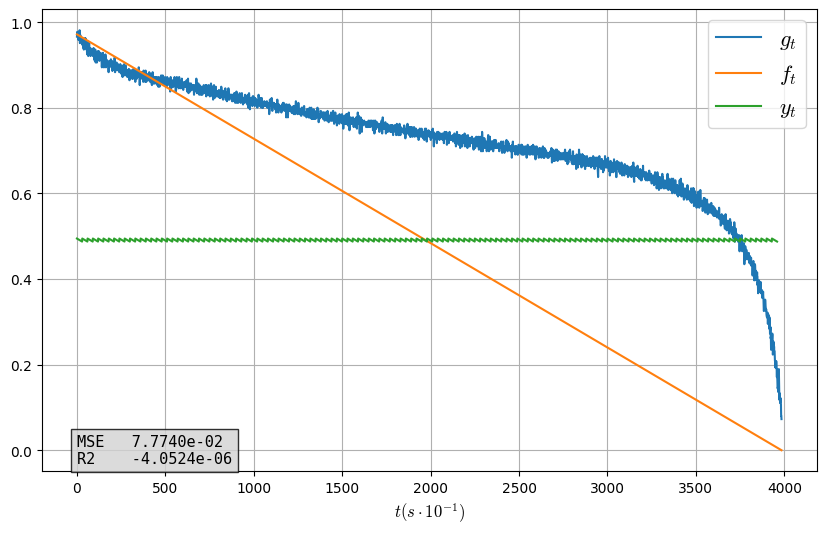

In [51]:
def evaluate_and_plot(data, model, n):
    model.eval()  # Set the model to evaluation mode
    
    g = data[0]  # Input function g
    f = data[1]  # True function f
    
    predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for i in range(0, len(g)-n, n):
            input_seq = g[i:i+n]
            # Convert to PyTorch tensor and add batch dimension
            X = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)
            y = model(X)
            predictions.extend(y.squeeze(0).numpy())  # Remove batch dimension and convert to numpy


    predictions = np.array(predictions)
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(g, label=r'$g_t$')
    plt.plot(f, label=r'${f_t}$')
    plt.plot(predictions, label=r'$y_t$')

    mse = mean_squared_error(f[:len(predictions)], predictions)
    r2 = r2_score(f[:len(predictions)], predictions)
    text = (
        f"{'MSE':<5} {mse:>.4e}\n"
        f"{'R2':<5} {r2:>.4e}"
    )

    plt.text(
        0.0, 0.0,
        text,
        fontsize=11,
        fontfamily="monospace",  # Use a monospaced font
        verticalalignment="center",  # Align text vertically
        horizontalalignment="left",  # Align text horizontally
        bbox=dict(facecolor="lightgray", alpha=0.8, edgecolor="black"),  # Add a background box
    )
    
    # Add labels and legend
    plt.xlabel(r'$t(s\cdot 10^{-1})$', fontsize=12)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()

train_data = make_data(train_dir)
#dataloader = create_dataloader(train_data, n, batch_size=batch_size, shuffle=True)
#train(num_epochs, dataloader, model, criterion, optimizer)
evaluate_and_plot(train_data, model, n)

In [57]:
checkpoint = {
    'seq_length': n,
    'input_size': n,
    'hidden_size': k,
    'output_size': n,
    'cutoff': cutoff,
    'norm_upper': norm_upper,
    'norm_lower': norm_lower,
    'sec_norm': sec_norm,
    'state_dict': model.state_dict(),
}
torch.save(checkpoint, 'bat_seq_model2.pth')